INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      144 non-null    object
 1   y       144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


  0%|          | 0/4 [00:00<?, ?it/s]

<Axes: xlabel='ds', ylabel='y'>

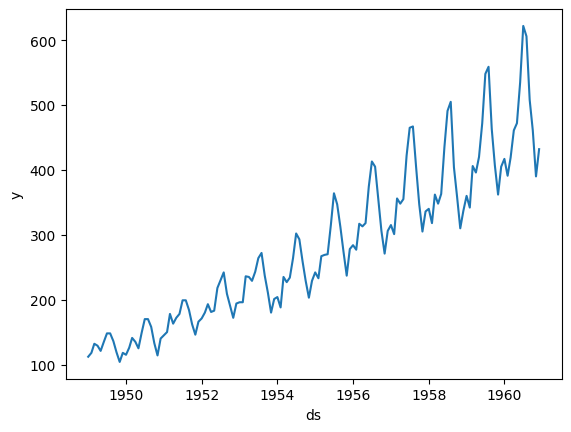

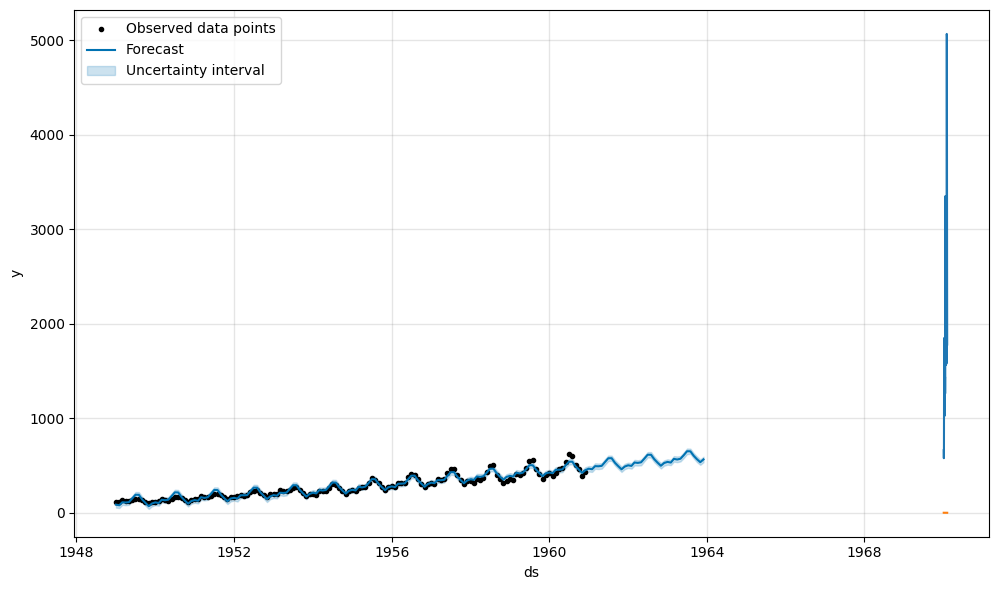

In [17]:
"""時系列分析とは、過去の時系列データにもとづいて、特徴や傾向の把握、将来予測などを行う分析手法
Prophetというライブラリを利用した時系列分析を実施する
時系列分析は、例えば以下のようなことに活用される：
・将来の株価を予測して、トレーディングを行う。
・ある空港で予測される将来の旅客数の推移で航空機のリース計画を検討する。
・運営しているブログの将来の閲覧数を予測し、副業収入の予測を立てる。"""
#1. 課題把握とゴールの設定
# ある空港の旅客数の過去の推移から、向こう3年の旅客数の推移を予測したい。
# どれくらい予測が的中しそうかも知りたい。
#分析のゴール
#向こう3年の旅客数の予測推移をグラフで可視化する。
#どの程度、予測が的中しそうか定量的に明示する。

#2. 必要なライブラリのインポート
import pandas as pd
import seaborn as sns

#3. データの準備
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv')
df
#12年分（144か月分、期間1949/1/1～1960/12/1）の旅客数データで、ds列に日付、y列に旅客数が配置されているデータ構成であることが分かります。
#旅客数推移のイメージをつかむため、折れ線グラフで可視化
time = pd.to_datetime(df['ds'])
sns.lineplot(x=time, y=df['y'])
#取り込んだデータにおける欠損の有無を確認
df.info()
#Prophetの仕様として、利用するデータセットは以下のルールに準じる必要があります。独自のデータを準備する場合は、注意してください。
#   時間データの列名は「ds」とすること
#   数値の列名は「y」とすること
#   y列の値は、数値データとすること

#4. 予測モデルの学習
#Prophetクラスをインポートし、インスタンス化
from prophet import Prophet
model = Prophet()
#df（過去の時系列データ）を引数に指定して、fitメソッドを実行
model.fit(df)

#5. 予測
#予測したい未来日時を含むDataFrameを作成する必要があります。
#予測期間を指定してmake_future_dataframeメソッドを実行することで、未来日時を含むDataFrameの枠組みを作成
future = model.make_future_dataframe(periods=36, freq='MS')
future
#当初の1960/12/1までの期間に加え、向こう3年の1963/12/1までの日付情報を持つDataFrameが生成
forecast = model.predict(future)
forecast
#不確実性区間の範囲内に、実際の旅客数の値がどの程度含まれているかの割合を推定
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#旅客数の予測値、不確実性区間が表示されました。これらの値をグラフ上に可視化
fig_forecast = model.plot(forecast)

#6. 予測の評価
#Prophetには、過去のデータを使って、複数パターンのテストを実施する機能がある
#テストパターンは、cutoffs(いつまでのデータを学習データとするかという期限の日付)と
#horizon(cutoffs翌日以降のテスト期間)という2つのパラメータで調整可能
#
cutoffs = pd.to_datetime(['1954-12-01', '1955-12-01', '1956-12-01', '1957-12-01'])
#テストパターンを作成するcross_validation関数をインポート
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '1096 days', cutoffs=cutoffs)
#出力されたdf_cvのデータを確認
df_cv
#評価指標を算出するperformance_metrics関数をインポート
from prophet.diagnostics import performance_metrics
#引数にdf_cvを指定して、performance_metrics関数を実行
df_p = performance_metrics(df_cv)
df_p.head()
#performance_metrics関数の実行時に、monthlyパラメータにTrueを指定して、horizon列を月単位で表示
df_p = performance_metrics(df_cv, monthly=True)
df_p.head()
#lineplot関数による旅客数推移の可視化とは異なりますが、dataパラメータにDataFrameを指定し、x・yパラメータに列名を指定することでも、折れ線グラフを描画可能
sns.lineplot(x='horizon', y='mse', data=df_p)
#不確実性区間に予測値が含まれている割合であるcoverageも、推移を可視化
sns.lineplot(x='horizon', y='coverage', data=df_p)
